In [1]:
import os.path as osp
import sys
from pathlib import Path
import matplotlib.pyplot as plt

root_path = Path(osp.abspath("")).parents[1]
sys.path.append(str(root_path))

%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
from core.curve import BSpline

## 生成控制点

In [3]:
def rodrigues_rotate(v, k, theta):

    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    k_dot_v = np.dot(k, v)
    k_cross_v = np.cross(k, v)

    return v * cos_theta + k_cross_v * sin_theta + k * k_dot_v * (1 - cos_theta)


def calculate_control_points(P1, P2, P3, L):

    # 计算单位向量 e1 和 e2
    e1 = (P1 - P2) / np.linalg.norm(P1 - P2)
    e2 = (P3 - P2) / np.linalg.norm(P3 - P2)
    theta = np.arccos(np.dot(e1, e2))
    print(f"theta: {theta}")
    # 计算垂直向量 n
    n = np.cross(e1, e2)
    n = n / np.linalg.norm(n)  # 确保 n 是单位向量

    # 计算角度 α
    alpha = 2 * np.arctan((1 / 3) + np.sin(theta / 2) * np.cos(theta / 2))
    print(f"alpha: {alpha}")

    # 计算 e3 和 e4
    rot_angle = (alpha - theta) / 2
    e3 = rodrigues_rotate(e1, n, -rot_angle)
    e4 = rodrigues_rotate(e2, n, rot_angle)

    # 计算控制点 N 的位置
    N4 = P2  # 控制点 N4 与 P2 重合
    N3 = N4 + L * e3
    N5 = N4 + L * e4

    # 计算对称点 N1 和 N6
    N1 = N2 = N4 + 4 * L * np.cos((alpha - theta) / 2) * e1
    N6 = N7 = N4 + 4 * L * np.cos((alpha - theta) / 2) * e2

    # 计算 N0 和 N8
    N0 = N4 + (4 * np.cos((alpha - theta) / 2) + 1) * L * e1
    N8 = N4 + (4 * np.cos((alpha - theta) / 2) + 1) * L * e2

    # 返回所有控制点的列表
    return np.array([N0, N1, N2, N3, N4, N5, N6, N7, N8])

In [4]:
# 示例使用
P1 = np.array([0, 0, 0])
P2 = np.array([3, 6, 0])
P3 = np.array([6, 0, 0])
L = 1.2

control_points = calculate_control_points(P1, P2, P3, L)
for i, point in enumerate(control_points):
    print(f"N{i}: {point}")

theta: 0.9272952180016123
alpha: 1.2654976700043663
N0: [0.34733698 0.69467395 0.        ]
N1: [0.88399329 1.76798658 0.        ]
N2: [0.88399329 1.76798658 0.        ]
N3: [2.2903636 5.032314  0.       ]
N4: [3. 6. 0.]
N5: [3.7096364 5.032314  0.       ]
N6: [5.11600671 1.76798658 0.        ]
N7: [5.11600671 1.76798658 0.        ]
N8: [5.65266302 0.69467395 0.        ]


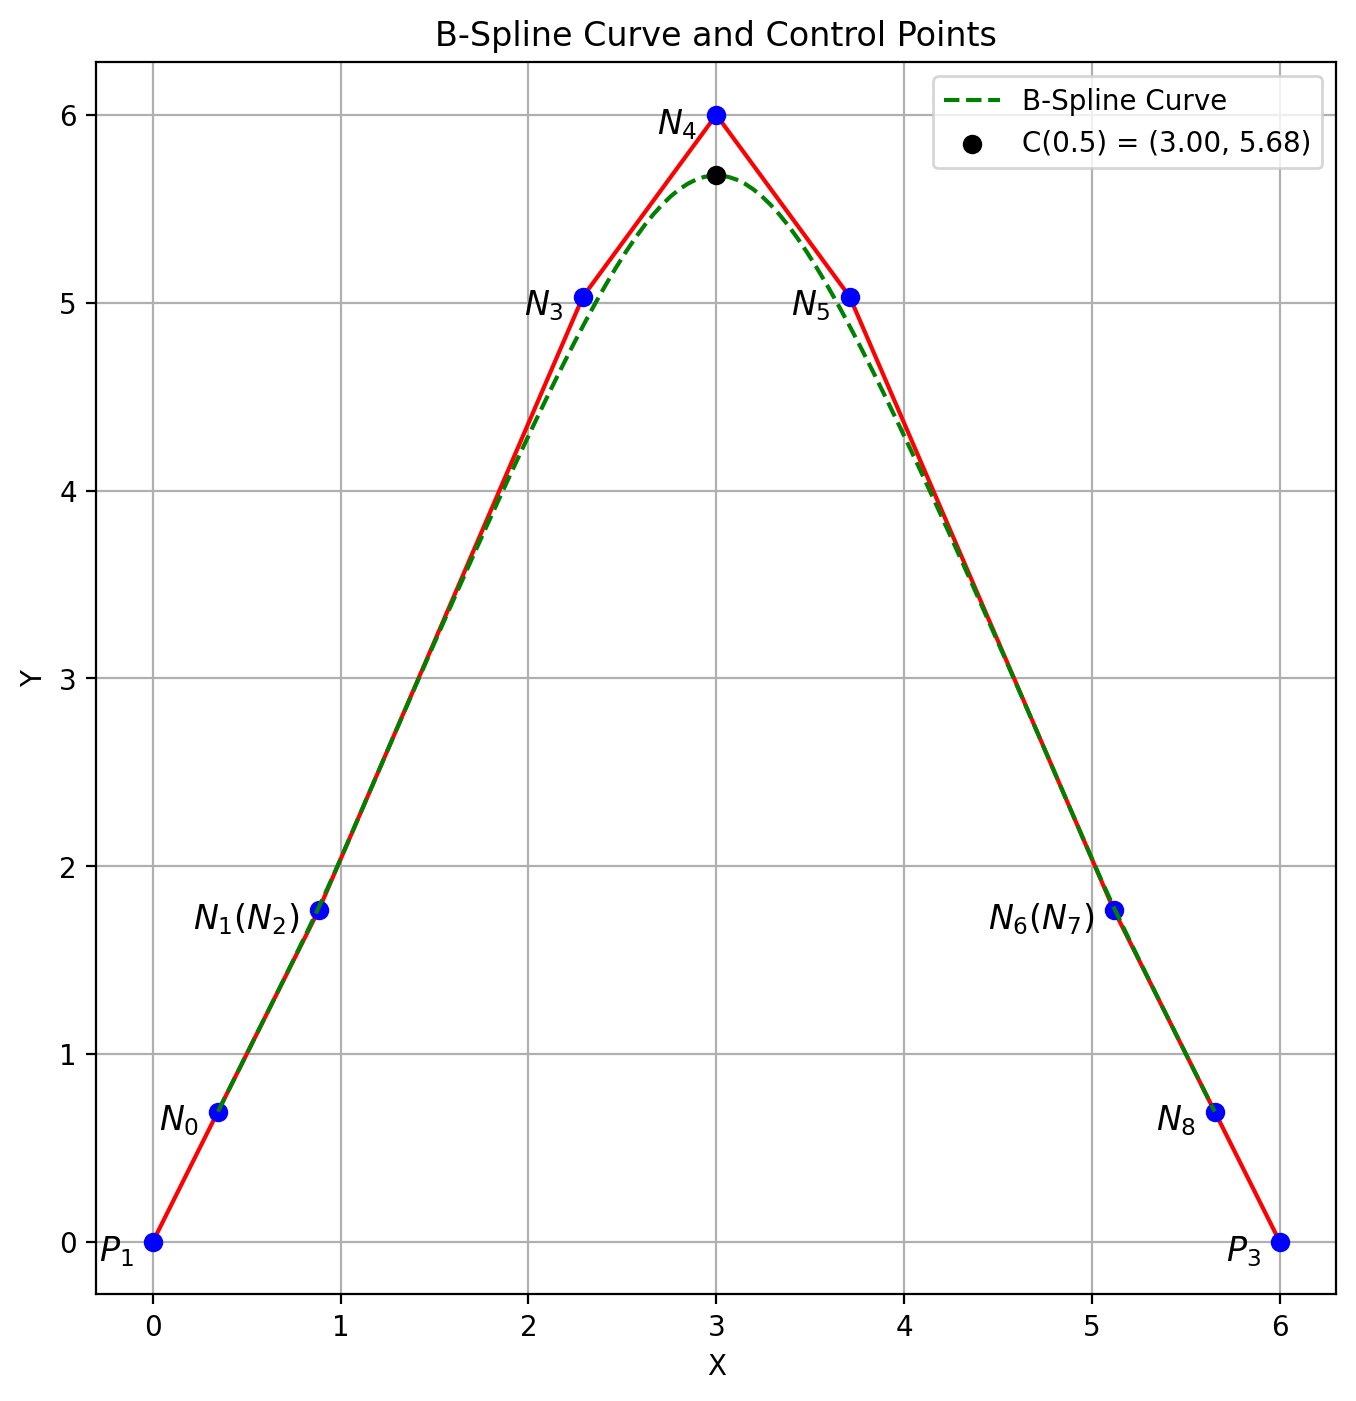

In [5]:
plt.figure(figsize=(8, 8))

line_points = np.array(
    [
        P1,
        control_points[0],
        control_points[1],
        control_points[3],
        control_points[4],
        control_points[5],
        control_points[7],
        control_points[8],
        P3,
    ]
)
line_labels = [r"$P_1$", r"$N_0$", r"$N_1(N_2)$", r"$N_3$", r"$N_4$", r"$N_5$", r"$N_6(N_7)$", r"$N_8$", r"$P_3$"]
plt.plot(line_points[:, 0], line_points[:, 1], "r-")
for point, label in zip(line_points, line_labels):
    plt.plot(point[0], point[1], "bo")
    plt.text(point[0] - 0.1, point[1] - 0.1, label, fontsize=12, ha="right")

knot_vector = [0, 0, 0, 0, 1 / 6, 2 / 6, 3 / 6, 4 / 6, 5 / 6, 1, 1, 1, 1]
k = 3
spline = BSpline(control_points, k, knot_vector)
pts = spline.get_points(100)
plt.plot(pts[:, 0], pts[:, 1], "g--", label="B-Spline Curve")

# 计算u=0.5处的样条曲线值
u_mid = 0.5
mid_point = spline(u_mid)
plt.scatter(mid_point[0], mid_point[1], color="k", zorder=5, label=f"C(0.5) = ({mid_point[0]:.2f}, {mid_point[1]:.2f})")

plt.xlabel("X")
plt.ylabel("Y")
plt.title("B-Spline Curve and Control Points")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()

### 验证 Eq(3) 的正确性

In [6]:
Eq3 = 1 / 6 * control_points[3] + 2 / 3 * control_points[4] + 1 / 6 * control_points[5]
print(f"Eq3 = {Eq3}")

Eq3 = [3.       5.677438 0.      ]


In [7]:
# 定义计算B样条基函数的递归函数
def B_spline_basis(j, k, u, knot_vector):
    if k == 0:
        if knot_vector[j] <= u < knot_vector[j + 1]:
            return 1.0
        else:
            return 0.0
    else:
        denom1 = knot_vector[j + k] - knot_vector[j]
        term1 = 0.0
        if denom1 != 0:
            term1 = (u - knot_vector[j]) / denom1 * B_spline_basis(j, k - 1, u, knot_vector)

        denom2 = knot_vector[j + k + 1] - knot_vector[j + 1]
        term2 = 0.0
        if denom2 != 0:
            term2 = (knot_vector[j + k + 1] - u) / denom2 * B_spline_basis(j + 1, k - 1, u, knot_vector)

        return term1 + term2


# 计算在u = 0.5时的B样条基函数值
basis_values = [B_spline_basis(j, k, 0.5, knot_vector) for j in range(len(knot_vector) - k - 1)]
print(f"Basis values at u = 0.5: {basis_values}")

Basis values at u = 0.5: [0.0, 0.0, 0.0, 0.1666666666666666, 0.6666666666666667, 0.1666666666666667, 0.0, 0.0, 0.0]


得到曲线的表达式为：

$$
C(0.5) = 0.1667 N_3 + 0.6667 N_4 + 0.1667 N_5 
$$

与公式 (3) 一致。

## B样条分割

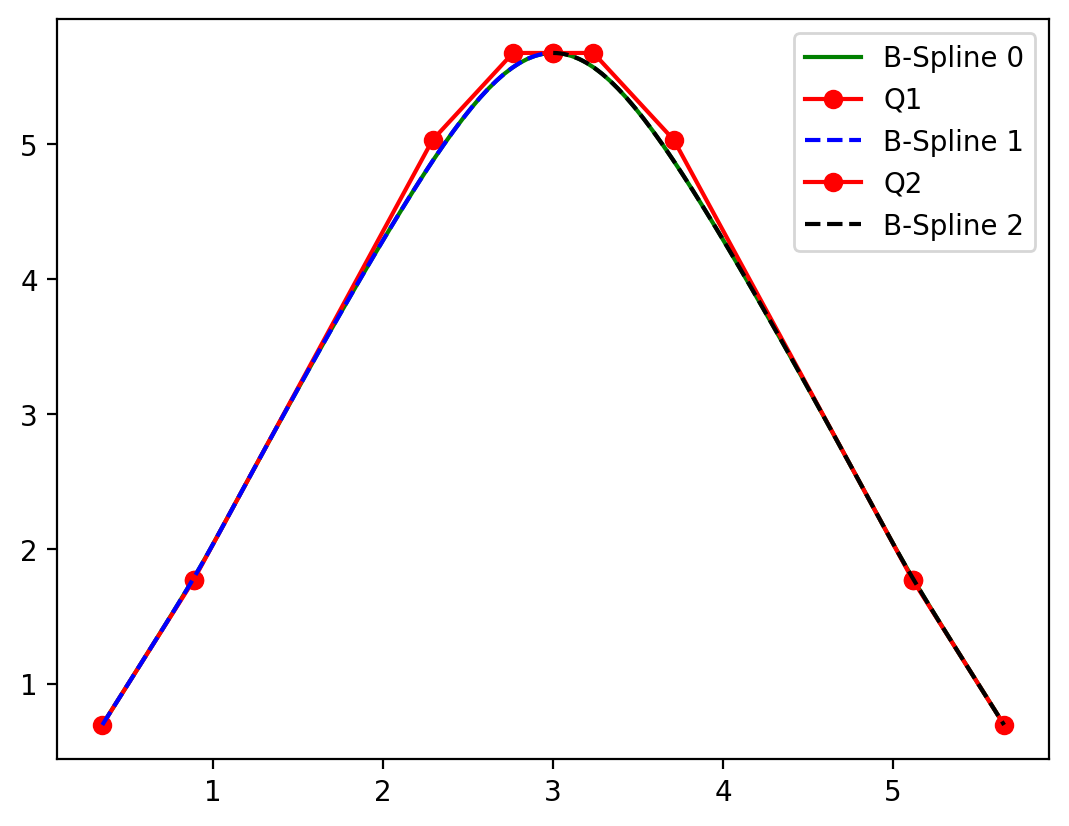

In [8]:
N0, N1, N2, N3, N4, N5, N6, N7, N8 = control_points
Q1 = np.array([N0, N1, N2, N3, N4 + 1 / 3 * (N3 - N4), mid_point])
Q2 = np.array([mid_point, N4 + 1 / 3 * (N5 - N4), N5, N6, N7, N8])
U1 = np.array([0, 0, 0, 0, 1 / 3, 2 / 3, 1, 1, 1, 1])
U2 = np.array([0, 0, 0, 0, 1 / 3, 2 / 3, 1, 1, 1, 1])

plt.plot(pts[:, 0], pts[:, 1], "g-", label="B-Spline 0")


plt.plot(Q1[:, 0], Q1[:, 1], "ro-", label="Q1")
b1 = BSpline(Q1, 3, U1)
p1 = b1.get_points(100)
plt.plot(p1[:, 0], p1[:, 1], "b--", label="B-Spline 1")

plt.plot(Q2[:, 0], Q2[:, 1], "ro-", label="Q2")
b2 = BSpline(Q2, 3, U2)
p2 = b2.get_points(100)
plt.plot(p2[:, 0], p2[:, 1], "k--", label="B-Spline 2")

plt.legend()
plt.show()

In [9]:
import numpy as np

np.float = np.float64

from geomdl import BSpline as BSplineGeomdl
from geomdl import operations
from geomdl import multi

curve = BSplineGeomdl.Curve()
curve.degree = 3
curve.ctrlpts = control_points.tolist()
curve.knotvector = knot_vector

curve_list = operations.split_curve(curve, 0.5)
curves = multi.CurveContainer(curve_list)

# 输出结果
print("第一段曲线的控制点:")
print(curve_list[0].ctrlpts)
print("第一段曲线的节点向量:")
print(curve_list[0].knotvector)

print("第二段曲线的控制点:")
print(curve_list[1].ctrlpts)
print("第二段曲线的节点向量:")
print(curve_list[1].knotvector)

第一段曲线的控制点:
[[0.3473369762746792, 0.6946739525493584, 0.0], [0.8839932908746286, 1.7679865817492573, 0.0], [0.8839932908746286, 1.7679865817492573, 0.0], [2.290363603646979, 5.032314004973154, 0.0], [2.763454534548993, 5.677438001657718, 0.0], [3.0, 5.677438001657718, 0.0]]
第一段曲线的节点向量:
[0.0, 0.0, 0.0, 0.0, 0.3333333333333333, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0]
第二段曲线的控制点:
[[3.0, 5.677438001657718, 0.0], [3.236545465451007, 5.677438001657718, 0.0], [3.709636396353021, 5.032314004973154, 0.0], [5.116006709125371, 1.7679865817492573, 0.0], [5.116006709125371, 1.7679865817492573, 0.0], [5.652663023725321, 0.6946739525493584, 0.0]]
第二段曲线的节点向量:
[0.0, 0.0, 0.0, 0.0, 0.33333333333333326, 0.6666666666666667, 1.0, 1.0, 1.0, 1.0]


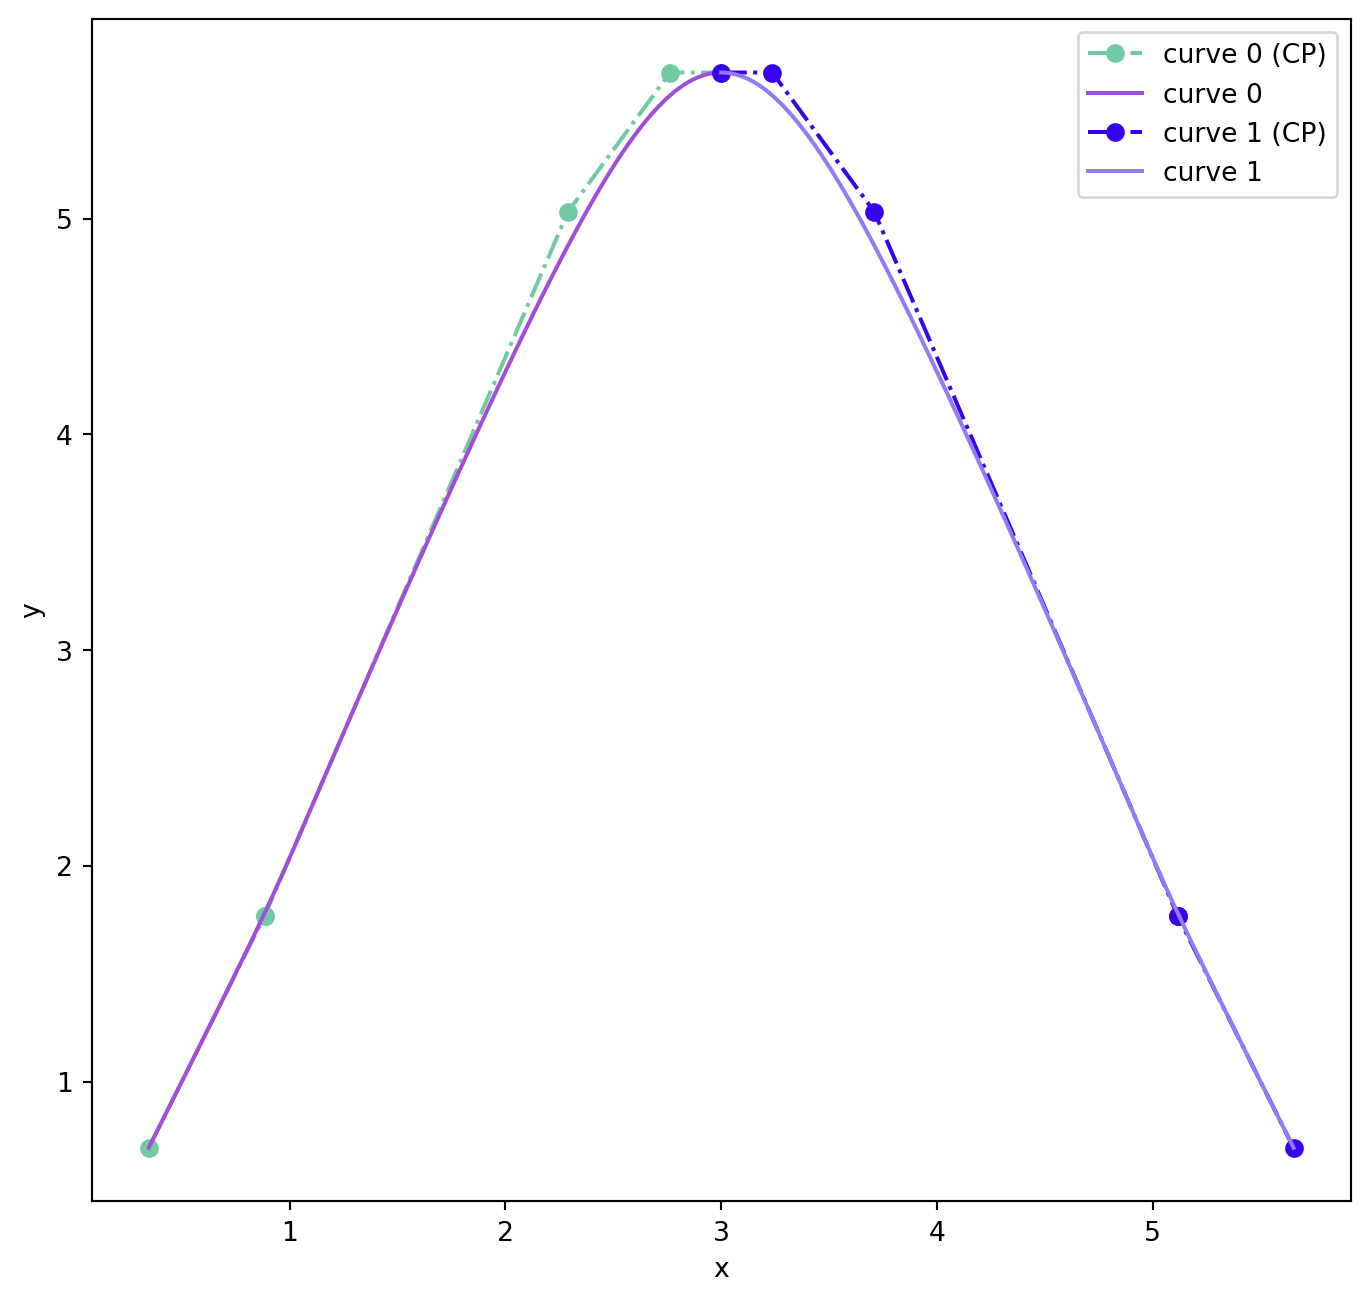

In [10]:
from geomdl.visualization import VisMPL

vis_comp = VisMPL.VisCurve2D()
curves.vis = vis_comp
curves.render()